In [28]:
import random
import scipy
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import minimize
from user_distributions import oneFarOneClose, leftSkewedNormal, leftUpSkewedNormal, leftUpRectangles, normalDistribution

# Seed random number generators
seed = 324
random.seed(seed)
np.random.seed(seed)
rng = np.random.default_rng(seed)

## Parameters
Constant parameters used for the simulation

In [ ]:
r_min = 1000 # meters
r_max = 15000 # meters
D = 10000 # meters
rD = 2000 # meters
cx_min = -20000 # meters
cx_max = 40000 # meters
cy_min = -20000
cy_max = 20000
v = 50 # meters/second

N = 200 # timeslots in one rotation
M = 2 # users
K = 20 # total number of users

# therefore, each user should get scheduled 40 times

H = 100 # meters
PAtx = 10 # watts
PUtx = 0.01 # watts
GT = 1
GR = 1
B = 1e6 # Hz
N0 = 10**((7.5-174+10*np.log10(B))/10)/1000 # watts
F = 2e9 # Hz
WAVELENGTH = scipy.constants.c / F # meters

## Constants for convenience
- `thetas` = UAV angle at each timeslot
- `cos_th` = $\cos(\text{UAV angle at each timeslot})$
- `sin_th` = $\sin(\text{UAV angle at each timeslot})$
- `CU` = $P^\text{U}_\text{tx} G_\text{T} G_\text{R} \left(\frac{\lambda}{4\pi}\right)^2$
- `CA` = $P^\text{A}_\text{tx} G_\text{T} G_\text{R} \left(\frac{\lambda}{4\pi}\right)^2$
- `AU` = $\frac{C_\text{U}M}{N_0}$
- `AB` = $\frac{C_\text{A}}{N_0}$ 

In [30]:
thetas = 2*np.pi*np.arange(N)/N
cos_th = np.cos(thetas)
sin_th = np.sin(thetas)
CU = PUtx*GT*GR*(WAVELENGTH/(4*np.pi))**2
CA = PAtx*GT*GR*(WAVELENGTH/(4*np.pi))**2
AU = (CU * M) / N0
AB = CA / N0

## User Generation
Here we define a function to randomly generate users within the deadzone. For the purposes of the simulation, we generate the maximum number of users. Smaller flight paths may not serve every user in one rotation, but the objective is normalized over timeslots. We plot the users at the end to verify that the distribution is correct.

len(users): 20
K: 20


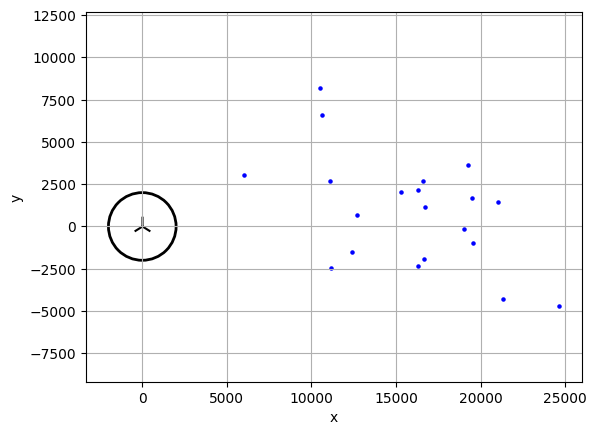

In [52]:
# users = leftUpRectangles(K, 5000, 1000, D, 0, seed=seed)
# users = leftUpSkewedNormal(K, D, 15000, D, 15000, seed)
users = normalDistribution(K, 1.5*D, 0, 3000, seed=seed)
print(f'len(users): {len(users)}')
print(f'K: {K}')

xs, ys = zip(*users)
plt.scatter(xs, ys, c='b', marker='o', s=5)
plt.scatter(0, 0, c='black', marker='2', s=200, label="Origin")
ax = plt.gca()  # get current axes
circle = patches.Circle((0, 0), radius=2000, fill=False, color='black', linewidth=2)
ax.add_patch(circle)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-10000, 10000)
plt.ylim(-10000, 10000)
plt.axis("equal")  # equal scaling
plt.show()

## Mean SE (objective function)
The average achievable spectral efficiency of the relay system over the timeslots is given as
$$\overline{\text{SE}}(\alpha, r, \mathbf{c}, a) = \frac{1}{N}\sum_{n=1}^N \min\left[\frac{\alpha}{M}\sum_{k=1}^K a_{n,k}\cdot\text{SE}^\text{UA}_{n,k}\;\mathbf{,}\;(1-\alpha)\cdot\text{SE}^\text{AB}_n\right]$$

In [32]:
def meanSE(alpha, 
           r, 
           cx, 
           cy, 
           a,
           users=users,
           AU=AU,
           AB=AB):

    # Compute UAV position at each timeslot
    ax = cx + r*cos_th
    ay = cy + r*sin_th

    # Compute squared distances
    snk0 = []
    for n in range(N):
        dx = ax[n] - users[:, 0]
        dy = ay[n] - users[:, 1]
        snk0.append(dx*dx + dy*dy + H*H)
    sbn0 = (ax*ax + ay*ay + H*H)

    # Calculate SEUA and SEAB
    seua = []
    for n in range(N):
        seua.append( (alpha/M) * np.sum(a[n] * np.log2(1.0 + AU/snk0[n])) )
    seab = (1-alpha)*np.log2(1.0 + AB/sbn0)

    # Calculate the mins
    min_se = [min(ua, ab) for ua, ab in zip(seua, seab)]

    # Return the average
    return np.mean(min_se)

## $\alpha$ Optimizer
Here I will define an optimizer to find the optimal $\alpha$ for a fixed $r$, $\mathbf{c}$.

In [33]:
def optimize_alpha(r, 
                   cx, 
                   cy, 
                   a, 
                   users=users, 
                   AU=AU,
                   AB=AB,
                   verbose=False):
    
    # Compute UAV position at each timeslot
    ax = cx + r*cos_th
    ay = cy + r*sin_th

    # Compute squared distances
    snk0 = []
    for n in range(N):
        dx = ax[n] - users[:, 0]
        dy = ay[n] - users[:, 1]
        snk0.append(dx*dx + dy*dy + H*H)
    sbn0 = (ax*ax + ay*ay + H*H)

    # Compute an and bn
    an = []
    for n in range(N):
        an.append(np.sum(a[n] * np.log2(1.0 + AU/snk0[n])))
    bn = np.log2(1.0 + AB/sbn0)

    alpha_var = cp.Variable()
    tn_var = cp.Variable(N)
    cons = []

    for n in range(N):
        cons += [ tn_var[n] <= (alpha_var/M) * an[n] ]
        cons += [ tn_var[n] <= (1 - alpha_var) * bn[n] ]

    cons += [alpha_var >= 0, alpha_var <= 1]

    obj = cp.Maximize( cp.mean(tn_var) )

    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.MOSEK, verbose=verbose)

    if prob.status not in ("optimal", "optimal_inaccurate"):
        raise RuntimeError(f"SCA subproblem infeasible/failed: status {prob.status}")
    
    return float(alpha_var.value)

## $a$ Optimizer

In [34]:
def optimize_a(alpha, 
               r, 
               cx, 
               cy, 
               users=users,
               AU=AU,
               AB=AB,
               verbose=False):
    
    # Compute UAV position at each timeslot
    ax = cx + r*cos_th
    ay = cy + r*sin_th

    # Compute squared distances
    snk0 = []
    for n in range(N):
        dx = ax[n] - users[:, 0]
        dy = ay[n] - users[:, 1]
        snk0.append(dx*dx + dy*dy + H*H)
    sbn0 = (ax*ax + ay*ay + H*H)

    # Calculate seua and seab
    seua = []
    for n in range(N):
        seua.append((alpha/M) * np.log2(1.0 + AU/snk0[n]))
    seab = (1-alpha) * np.log2(1.0 + AB/sbn0)

    # define CVXPY variables
    a_vars = cp.Variable((N, K))
    t_vars = cp.Variable(N)

    # Constraints
    cons = []

    # Add tn constraints
    for n in range(N):
        cons += [
            t_vars[n] <= cp.sum(cp.multiply(a_vars[n], seua[n]))
        ]

        cons += [
            t_vars[n] <= seab[n]
        ]
    
    # Limit a_vars in between 0 and 1
    for n in range(N):
        for k in range(K):
            cons += [ a_vars[n][k] >= 0, a_vars[n][k] <= 1 ]
    
    # Column sum constraint: each user at most once
    cons += [ cp.sum(a_vars[:, k]) <= (N*M)/K for k in range(K) ]

    # Row sum constraint: at most M users per timeslot
    cons += [ cp.sum(a_vars[n, :]) <= M for n in range(N) ]

    # Want to maximize tn
    obj = cp.Maximize( cp.mean(t_vars) )

    # Solve problem and check convergence
    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.MOSEK, verbose=verbose)

    if prob.status not in ("optimal", "optimal_inaccurate"):
        raise RuntimeError(f"SCA subproblem infeasible/failed: status {prob.status}")
    
    # Return a array
    a = []
    for n in range(N):
        row = []
        for k in range(K):
            row.append(a_vars[n][k].value)
        a.append(row)
    
    return a

## Powell's optimizer for $\alpha$, $r$, $\mathbf{c}$
Here I define a block optimizer to iteratively optimize $\alpha$, $r$, $\mathbf{c}$.

Powell's Optimizer Iteration 0
    Values at iteration 0: alpha = 0.5, r=8000.0, c=(10000.0, 0.0)
    User scheduling optimized
    Timeshare optimized
    Trajectory optimized, result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 1
    Values at iteration 1: alpha = 0.5681820322074864, r=3022.0854738355238, c=(12881.996276609498, 406.4137790209206)
    User scheduling optimized
    Timeshare optimized
    Trajectory optimized, result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 2
    Values at iteration 2: alpha = 0.5681820322522225, r=3022.08567902693, c=(12916.20613829438, 393.81229823091473)
    User scheduling optimized
    Timeshare optimized
    Trajectory optimized, result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 3
    Values at iteration 3: alpha = 0.5681820322547261, r=3022.0856310297213, c=(12954.22325611093, 387.5977092182755)
    User scheduling optimized
    Timeshare optimi

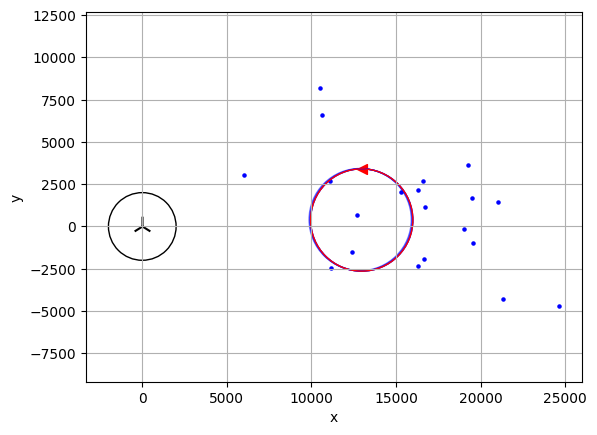

In [35]:
def objective(params, alpha, a, users, AU, AB):
    r, cx, cy = params
    return -meanSE(alpha, 
                   r, 
                   cx, 
                   cy, 
                   a, 
                   users=users,
                   AU=AU,
                   AB=AB)

def powells_optimizer(
                    alpha0,
                    r0, 
                    cx0, 
                    cy0, 
                    rbounds=(r_min, r_max),
                    cxbounds=(cx_min, cx_max),
                    cybounds=(cy_min, cy_max),
                    users=users,
                    AU=AU,
                    AB=AB,
                    tolerance=1e-3
):

    alpha = alpha0
    r = r0
    cx = cx0
    cy = cy0
    bounds = [rbounds, cxbounds, cybounds]

    traj_history = []
    obj_history = []

    it = 0
    while True:
        print(f'Powell\'s Optimizer Iteration {it}')
        print(f'    Values at iteration {it}: alpha = {alpha}, r={r}, c=({cx}, {cy})')

        a = optimize_a(alpha, 
                       r, 
                       cx, 
                       cy, 
                       users=users,
                       AU=AU,
                       AB=AB)
        print('    User scheduling optimized')

        alpha = optimize_alpha(r,
                               cx,
                               cy,
                               a,
                               users=users,
                               AU=AU,
                               AB=AB)
        print('    Timeshare optimized')
        
        result = minimize(
                    objective,
                    [r,cx,cy],
                    args=(alpha, a, users, AU, AB),
                    method='Powell',
                    bounds=bounds,
                    options={
                        'maxiter':1000,
                        'xtol':1e-3,
                        'ftol':1e-3
                    }
        )
        print(f'    Trajectory optimized, result.message: {result.message}')
        print()

        r, cx, cy = result.x

        obj_history.append(meanSE(alpha, 
                                  r, 
                                  cx, 
                                  cy, 
                                  a, 
                                  users=users,
                                  AU=AU,
                                  AB=AB))
        traj_history.append((r, cx, cy))

        if it > 0:
            if ( (obj_history[-1] - obj_history[-2])/obj_history[-2] < tolerance):
                break
        it += 1
    
    return alpha, a, traj_history
        
alpha0 = 0.5
r0 = (r_min + r_max) / 2
cx0 = (cx_min + cx_max) / 2
cy0 = (cy_min + cy_max) / 2

alpha_opt, a_opt, traj_hist = powells_optimizer(alpha0, r0, cx0, cy0)
r_opt, cx_opt, cy_opt = traj_hist[-1]

print(f'Optimal alpha: {alpha_opt}')
print(f'Optimal radius: {r_opt}')
print(f'Optimal center point: ({cx_opt}, {cy_opt})')
print(f'Achievable SE: {meanSE(alpha_opt, r_opt, cx_opt, cy_opt, a_opt)}')

xs, ys = zip(*users)
plt.scatter(xs, ys, c='b', marker='o', s=5)
plt.scatter(0, 0, c='black', marker='2', s=200, label="Origin")
plt.scatter(cx_opt, cy_opt+r_opt, c='r', marker='<', s=50, label="UAV")
ax = plt.gca()  # get current axes
coverage_zone = patches.Circle((0, 0), radius=2000, fill=False, color='black', linewidth=1)
flight_path = patches.Circle((cx_opt, cy_opt), radius=r_opt, fill=False, color='red', linewidth=1)

for traj in traj_hist:
    r, cx, cy = traj
    path = patches.Circle((cx, cy), radius=r, fill=False, color='blue', alpha=0.5, linewidth=1)
    ax.add_patch(path)

ax.add_patch(coverage_zone)
ax.add_patch(flight_path)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-10000, 10000)
plt.ylim(-10000, 10000)
plt.axis("equal")  # equal scaling
plt.show()


## Successive convex approximation

SCA Optimizer Iteration 0
    MOSEK Iteration 0
    MOSEK Iteration 1
    MOSEK Iteration 2
    MOSEK Iteration 3
SCA Iteration 0 results:
alpha = 0.7394901089730458, radius = 1000.0000189190661, center = (8659.707981228736, 211.80077007718504)

SCA Optimizer Iteration 1
    MOSEK Iteration 0
    MOSEK Iteration 1
    MOSEK Iteration 2
SCA Iteration 1 results:
alpha = 0.6773317820583075, radius = 1000.0000184554319, center = (8655.033226962087, 212.4467456946567)

SCA Optimizer Iteration 2
    MOSEK Iteration 0
    MOSEK Iteration 1
SCA Iteration 2 results:
alpha = 0.6713496561197608, radius = 1000.0000373666184, center = (8705.444991725675, 216.85942036536358)

SCA Optimizer Iteration 3
    MOSEK Iteration 0
    MOSEK Iteration 1
    MOSEK Iteration 2
    MOSEK Iteration 3
    MOSEK Iteration 4
    MOSEK Iteration 5
    MOSEK Iteration 6
    MOSEK Iteration 7
    MOSEK Iteration 8
    MOSEK Iteration 9
SCA Iteration 3 results:
alpha = 0.6678513437770989, radius = 1000.0000360900184, c

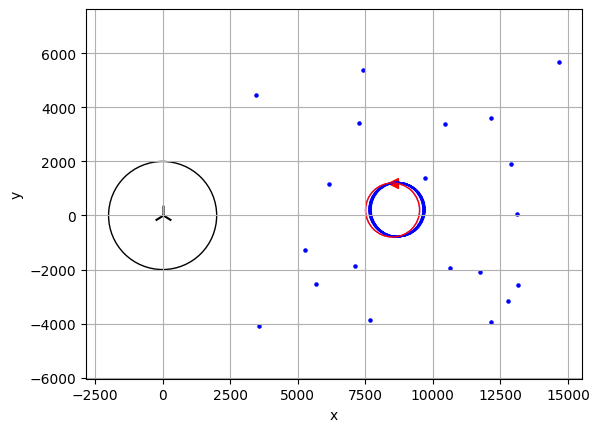

In [ ]:
def sca_optimizer(
                alpha0, 
                r0, 
                cx0, 
                cy0,
                r_bounds=(r_min, r_max), 
                cx_bounds=(cx_min, cx_max), 
                cy_bounds=(cy_min, cy_max),
                users=users,
                AU=AU,
                AB=AB,
                tol=1e-3,
                mosek_tol=1e-3,
                max_mosek_iters=30,
                verbose=False
):
    
    alpha = alpha0
    r = r0
    cx = cx0
    cy = cy0

    def f_and_grad(s, A):
        """Return f(s)=log2(1+A/s) and f'(s) = -A/(ln2*s*(s+A)) elementwise."""
        s = np.asarray(s, dtype=float)
        f = 1e7*np.log2(1.0 + A/np.maximum(s,1e-9))
        fp = 1e7*-(A) / (np.log(2.0) * np.maximum(s,1e-9) * (np.maximum(s,1e-9) + A))
        return f, fp
    
    traj_hist = []
    obj_hist = []

    it = 0
    while True:
        print(f'SCA Optimizer Iteration {it}')

        # schedule optimization
        a = optimize_a(alpha,
                       r,
                       cx,
                       cy,
                       users=users,
                       AU=AU,
                       AB=AB)

        # alpha optimization
        alpha = optimize_alpha(r,
                               cx,
                               cy, 
                               a, 
                               users=users,
                               AU=AU,
                               AB=AB)

        mosek_obj_hist = []

        # r, c optimization
        for mosek_it in range(max_mosek_iters):
            print(f'    MOSEK Iteration {mosek_it}')

            # Compute UAV coords
            ax = cx + r*cos_th
            ay = cy + r*sin_th

            # Compute squared distances
            snk0 = []
            for n in range(N):
                dx = ax[n] - users[:, 0]
                dy = ay[n] - users[:, 1]
                snk0.append(dx*dx + dy*dy + H*H)
            sbn0 = (ax*ax + ay*ay + H*H)            

            # Evaluate f and gradients at current s
            fU0 = []
            gU0 = []
            for n in range(N):
                fu, gu = f_and_grad(snk0[n], AU)
                fU0.append(fu)
                gU0.append(gu)
            fB0, gB0 = f_and_grad(sbn0, AB)

            # CVXPY variables
            r_var  = cp.Variable()
            cx_var = cp.Variable()
            cy_var = cp.Variable()
            t = cp.Variable(N)  # timeslot min-SE terms

            # Auxiliary upper-bounds for squared distances
            s_vars = cp.Variable((N, K))  # s_{n,k}
            sb_var = cp.Variable(N)  # b^2_n

            cons = []

            # Geometric "upper-bound" constraints: s >= true squared distance
            for n in range(N):
                # planar expressions are affine in (r,cx,cy)
                ax_n = cx_var + r_var*cos_th[n]
                ay_n = cy_var + r_var*sin_th[n]

                # user distances
                xk = users[:, 0]
                yk = users[:, 1]

                # ||(ax_n - xk, ay_n - yk)||^2 + H^2  <=  s_vars[n]  (as lower-bound on SE we want s_vars >= true)
                # Implement via rotated quadratic cone: s >= (ax_n - x)^2 + (ay_n - y)^2 + H^2
                # In cvxpy, simple convex way is: s >= (ax_n - x)^2 + (ay_n - y)^2 + H^2
                cons += [ s_vars[n] >= (ax_n - xk)**2 + (ay_n - yk)**2 + (H**2) ]

                # AB link
                cons += [ sb_var[n] >= (ax_n)**2 + (ay_n)**2 + (H**2) ]
            
            # Linearized (conservative) SE constraints per slot:
            # t_n <= (alpha/M) sum_k [ fU0 + gU0 * (s - s0) ]
            # t_n <= (1-alpha)      [ fB0 + gB0 * (sb - sb0) ]
            for n in range(N):
                # UA side
                linearized_seua = fU0[n] + cp.multiply(gU0[n], s_vars[n] - snk0[n])  # length K
                weighted_seua = cp.multiply(a[n], linearized_seua)  

                cons += [
                    t[n] <= ((alpha/M) *  cp.sum(weighted_seua))
                ]

                # AB size
                linearized_seab = fB0[n] + cp.multiply(gB0[n], sb_var[n] - sbn0[n])

                # AB side
                cons += [
                    t[n] <= ((1.0 - alpha) * linearized_seab)
                ]
            
            # Add parameter bounds
            r_min, r_max = r_bounds
            cons += [ r_var >= r_min, r_var <= r_max ]
            
            cx_min, cx_max = cx_bounds
            cons += [ cx_var >= cx_min, cx_var <= cx_max ]
            
            cy_min, cy_max = cy_bounds
            cons += [ cy_var >= cy_min, cy_var <= cy_max ]

            # Solve objective
            obj = cp.Maximize( cp.mean(t) )
            prob = cp.Problem(obj, cons)
            prob.solve(solver=cp.MOSEK, verbose=verbose)

            if prob.status not in ("optimal", "optimal_inaccurate"):
                raise RuntimeError(f"    MOSEK subproblem infeasible/failed at iter {mosek_it}: status {prob.status}")
            
            # Update iterate
            r = float(r_var.value)
            cx = float(cx_var.value)
            cy = float(cy_var.value)

            traj_hist.append((r, cx, cy))
            mosek_obj_hist.append(float(np.mean(t.value)))

            if mosek_it > 0:
                if (mosek_obj_hist[-1] - mosek_obj_hist[-2])/max(1e-9, mosek_obj_hist[-2]) < mosek_tol:
                    break
        
        # Print iteration results
        print(f'SCA Iteration {it} results:')
        print(f'alpha = {alpha}, radius = {r}, center = ({cx}, {cy})')
        print()
        
        # Check for convergence
        obj_hist.append(meanSE(alpha,
                               r,
                               cx,
                               cy,
                               a,
                               users=users,
                               AU=AU,
                               AB=AB))
        if it > 0:
            if (obj_hist[-1] - obj_hist[-2])/max(1e-9, obj_hist[-2]) < tol:
                break
        
        it += 1
    
    return alpha, a, traj_hist

alpha0 = 0.5
r0 = (r_min + r_max) / 2
cx0 = (cx_min + cx_max) / 2
cy0 = (cy_min + cy_max) / 2

alpha_opt, a_opt, traj_hist = sca_optimizer(alpha0, r0, cx0, cy0)
r_opt, cx_opt, cy_opt = traj_hist[-1]

print(f'Optimal alpha: {alpha_opt}')
print(f'Optimal radius: {r_opt}')
print(f'Optimal center point: ({cx_opt}, {cy_opt})')
print(f'Achievable SE: {meanSE(alpha_opt, r_opt, cx_opt, cy_opt, a_opt)}')

xs, ys = zip(*users)
plt.scatter(xs, ys, c='b', marker='o', s=5)
plt.scatter(0, 0, c='black', marker='2', s=200, label="Origin")
plt.scatter(cx_opt, cy_opt+r_opt, c='r', marker='<', s=50, label="UAV")
ax = plt.gca()  # get current axes
coverage_zone = patches.Circle((0, 0), radius=2000, fill=False, color='black', linewidth=1)
flight_path = patches.Circle((cx_opt, cy_opt), radius=r_opt, fill=False, color='red', linewidth=1)

for traj in traj_hist:
    r, cx, cy = traj
    path = patches.Circle((cx, cy), radius=r, fill=False, color='blue', alpha=0.5, linewidth=1)
    ax.add_patch(path)

ax.add_patch(coverage_zone)
ax.add_patch(flight_path)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-10000, 10000)
plt.ylim(-10000, 10000)
plt.axis("equal")  # equal scaling
plt.show()

## Spectral efficiency histogram
Here I will generate a histogram to show the spectral efficiency achieved by each user

In [50]:
def histogram(alpha,
              r, 
              cx, 
              cy, 
              a, 
              users=users,
              AU=AU,
              AB=AB):
    
    user_se = np.asarray([0.0] * K)

    # Compute UAV position at each timeslot
    ax = cx + r*cos_th
    ay = cy + r*sin_th

    # Compute squared distances
    snk0 = []
    for n in range(N):
        dx = ax[n] - users[:, 0]
        dy = ay[n] - users[:, 1]
        snk0.append(dx*dx + dy*dy + H*H)
    sbn0 = (ax*ax + ay*ay + H*H)

    # Calculate seua and seab
    seua = []
    for n in range(N):
        seua.append(alpha * a[n] * np.log2(1.0 + AU/snk0[n]))
    seab = (1-alpha) * np.log2(1.0 + AB/sbn0)

    for n in range(N):
        timeslot_seua = np.sum(seua[n]) / M
        timeslot_seab = seab[n]

        if (timeslot_seua < timeslot_seab):
            user_se += seua[n]
        else:
            ratio = timeslot_seab / timeslot_seua
            user_se += seua[n] * ratio
    
    user_se /= N*M/K

    plt.hist(user_se, bins=20, edgecolor='black')
    plt.xlabel("Average SE")
    plt.ylabel("# of Users")
    plt.show()

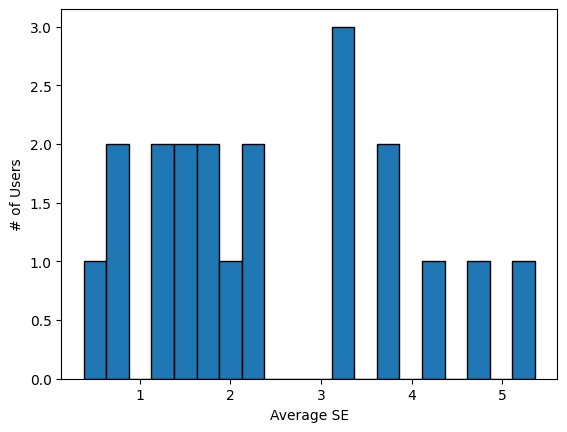

In [51]:
histogram(alpha_opt, r_opt, cx_opt, cy_opt, np.asarray(a_opt))

## Variance vs. gain over baselines

********** variance = 1000 **********
Powell's Optimizer Iteration 0
    Values at iteration 0: alpha = 0.5, r=1000, c=(15000.0, 0)
    User scheduling optimized
    Timeshare optimized
    Trajectory optimized, result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 1
    Values at iteration 1: alpha = 0.4994623420516113, r=1000.0003451834905, c=(15000.507997378123, 1.4444225672375743)
    User scheduling optimized
    Timeshare optimized
    Trajectory optimized, result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 2
    Values at iteration 2: alpha = 0.4989321615062034, r=1000.0003451834956, c=(15000.934299467488, 2.7219524914050153)
    User scheduling optimized
    Timeshare optimized
    Trajectory optimized, result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 3
    Values at iteration 3: alpha = 0.49843561554184207, r=1000.0003451834956, c=(15001.313902766151, 3.855107697263343)
    User s

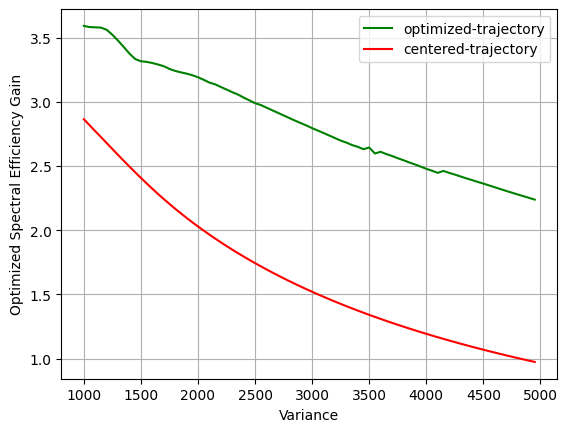

In [60]:
def random_schedule(maxiters=1000, tol=1e-9):
    mat = np.random.rand(N, K)

    for _ in range(maxiters):
        # Scale rows
        row_sums = mat.sum(axis=1, keepdims=True)
        mat *= (M / row_sums)

        # Scale columns
        col_sums = mat.sum(axis=0, keepdims=True)
        mat *= ( (N*M/K) / col_sums)

        # Check convergence
        if (np.allclose(mat.sum(axis=1), M, atol=tol) and
            np.allclose(mat.sum(axis=0), N, atol=tol)):
            break

    return mat

def variance_gain():
    variances = np.arange(1000, 5000, 50)

    alpha0 = 0.5
    r0 = r_min
    cx0 = 1.5*D
    cy0 = 0
    a0 = random_schedule()

    optimized = []
    centered = []

    for variance in variances:
        print(f'********** variance = {variance} **********')
        users = normalDistribution(K, 1.5*D, 0, variance, seed=seed)

        centered.append(meanSE(alpha0,
                               r0,
                               cx0,
                               cy0,
                               a0,
                               users=users))
        
        alpha_opt, a_opt, traj_hist = powells_optimizer(
                            alpha0,
                            r0,
                            cx0,
                            cy0,
                            users=users)
        r_opt, cx_opt, cy_opt = traj_hist[-1]

        optimized.append(meanSE(alpha_opt,
                                r_opt,
                                cx_opt,
                                cy_opt,
                                a_opt,
                                users=users))

    plt.plot(variances, optimized, c='g', label='optimized-trajectory')
    plt.plot(variances, centered, c='r', label='centered-trajectory')
    plt.grid(True)
    plt.xlabel("Variance")
    plt.ylabel("Optimized Spectral Efficiency Gain")
    plt.legend()
    plt.show()        

variance_gain()

## $P^\text{A}_\text{tx}$ vs. $r$ plot
Here I will generate a plot which shows how the radius decreases as $P^\text{A}_\text{tx}$ increase

In [54]:
def patx_plot(iterations=100):
    PAtx_arr = np.arange(1, 10, 1)

    radii = [0.0] * len(PAtx_arr)

    # Starting conditions
    alpha0 = 0.5
    r0 = r_min
    cx0 = D/2
    cy0 = 0
    for it in range(iterations):
        print("***************************************************************")
        print(f"Outer loop iteration {it}")
        print("***************************************************************")
        users = normalDistribution(K, 1.5*D, 0, 3000, seed=seed)

        for i, PAtx in enumerate(PAtx_arr):
            print("-----------------------------------------------------------")
            print(f"PAtx: {PAtx}")
            print("-----------------------------------------------------------")

            # Define AB for PAtx
            CA = PAtx*GT*GR*(WAVELENGTH/(4*np.pi))**2
            AB = CA / N0

            alpha_opt, a_opt, traj_hist = powells_optimizer(alpha0, r0, cx0, cy0, AB=AB)
            r_opt, cx_opt, cy_opt = traj_hist[-1]

            radii[i] += r_opt
    
    radii = np.asarray(radii)
    radii /= iterations
    
    plt.scatter(PAtx_arr, radii, c='g', marker='>', s=5)
    plt.grid(True)
    plt.xlabel("PAtx")
    plt.ylabel("Optimal radius")
    plt.show()      
    
patx_plot()

***************************************************************
Outer loop iteration 0
***************************************************************
-----------------------------------------------------------
PAtx: 1
-----------------------------------------------------------
Powell's Optimizer Iteration 0
    Values at iteration 0: alpha = 0.5, r=1000, c=(5000.0, 0)
    User scheduling optimized
    Timeshare optimized
    Trajectory optimized, result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 1
    Values at iteration 1: alpha = 0.777022248514197, r=1000.000248271612, c=(11914.40129177813, 234.23478007497454)
    User scheduling optimized
    Timeshare optimized
    Trajectory optimized, result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 2
    Values at iteration 2: alpha = 0.6754583132840063, r=1000.0003451834956, c=(12962.012120919382, 589.234886973406)
    User scheduling optimized
    Timeshare optimized
    Tra

KeyboardInterrupt: 